In [1]:
import numpy as np
import math
import operator
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms,gp
import dimod
import dwave_networkx as dnx
from operator import itemgetter
import tsplib95
import copy
import pygraphviz as pgv
from IPython.display import Image 

In [2]:
problem = tsplib95.load('./asymmetric_problems/ft70.atsp')
# problem = tsplib95.load('./symmetric_problems/berlin52.tsp')
G = problem.get_graph()
# tsp_problem = problem.as_keyword_dict()
# list(problem.get_nodes())

In [3]:
pos = nx.random_layout(G)

In [4]:
G.is_directed()

True

In [5]:
G.edges[0,1]['weight']

375

In [6]:
def plotRandomLayoutGraph(G,show_weights=False):
    pos = nx.random_layout(G)
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [ ]:
plotRandomLayoutGraph(G)

In [7]:
G.edges[0,1]["weight"]

375

### DEAP EVOLUTIONARY ALGORITHMS

In [ ]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
toolbox.register("indices", np.random.permutation, len(G.nodes))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [8]:
def evaluation(individual):
    total_weights = []
    for index in range(len(individual)-1):
        total_weights.append(G.edges[individual[index],individual[index+1]]['weight'])
        
    total_weights.append(G.edges[individual[len(individual)-1],individual[0]]['weight'])
    

    
    return (sum(total_weights),)

In [ ]:
def create_tour(individual):
    new_graph = nx.Graph()
    new_graphG=nx.complete_graph(len(individual))
    new_graph.clear_edges()
    for index in range(len(individual)-1):
        new_graph.add_edge(individual[index],individual[index+1])
    new_graph.add_edge(individual[len(individual)-1],individual[0])
    
    return new_graph

In [ ]:
toolbox.register("evaluate", evaluation)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
pop = toolbox.population(n=100)

In [ ]:
evaluation(pop[5])

In [ ]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [ ]:
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False,stats=fit_stats)

In [ ]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

In [ ]:
G = create_tour(best_individual)

In [ ]:
plotRandomLayoutGraph(G)

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("ft70 assymetric graph")
plt.savefig()

### GENETIC PROGRAMMING

In [9]:
def Div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [10]:
def Mod(left, right):
    try:
        return left % right
    except ZeroDivisionError:
        return 1

In [11]:
pset = gp.PrimitiveSet("MAIN",5)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(Mod, 2)
#Number of nodes in the graph
pset.renameArguments(ARG0="Nn")
#Number of remaining nodes to visit
pset.renameArguments(ARG1="Nrn")
#Distance from the current node
pset.renameArguments(ARG2="Dcn")
#Distance from the initial node
pset.renameArguments(ARG3="Din")
#Distance from the centroid of the nodes
# pset.renameArguments(ARG0="Dc")
# #Predicted distance from the initial node
pset.renameArguments(ARG4="Pd")
# #Distance left estimation
# pset.renameArguments(ARG0="Dle")

In [12]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [13]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [14]:
G.edges[0,1]['weight']

375

In [15]:
def nearest_neighbor(current,unvisited_nodes, G):
    min_node = min(unvisited_nodes, key=lambda x: G.edges[x, current]["weight"])
    return min_node

In [16]:
def greedy_TSP(G,visited):
    vis = copy.deepcopy(visited)
    while len(vis) < 52:
        C = nearest_neighbor(vis[-1], np.setdiff1d(list(G.nodes),vis),G)
        vis.append(C)
    vis.append(vis[0])
    score = evaluation(vis)[0]
    return score

In [17]:
def evaluate(individual,G):
    
    new_graph = copy.deepcopy(G)
    
    
    new_graph.clear_edges()
    tree = gp.PrimitiveTree(individual)
    
    node_results = [0]
    current_node = 0
    initial_node =0
    visited = [0]
    solution = [0]
    for i in range(len(G.nodes)):
        results = []
        for index in range(len(G.nodes)):
            if index not in visited:
                Nn = len(G.nodes())
                Nrn = len(np.setdiff1d(list(G.nodes),visited))
                Dcn = G.edges[current_node,index]['weight']
                Din = G.edges[initial_node,index]['weight']
                Pd = greedy_TSP(G,visited)
                result = toolbox.compile(expr=individual)
                results.append({"result": result(Nn,Nrn,Dcn,Din,Pd),"node":index})
        if not results:
            break
        nearest = min(results, key=lambda x:x['result'])
        new_graph.add_edge(current_node,nearest["node"],weight=G.edges[current_node,nearest["node"]]['weight'])
        solution.append(nearest["node"])
        current_node = nearest["node"]
        visited.append(nearest["node"])

    new_graph.add_edge(initial_node,solution[len(solution)-1])
    solution.append(initial_node)
    return evaluation(solution)

In [18]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evaluate, G= G)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [19]:
evaluate(toolbox.individual(),G)

(10073360,)

In [20]:
pop = toolbox.population(n=10)

In [21]:
# stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
# stats_size = tools.Statistics(len)
# mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
# mstats.register("avg", np.mean)
# mstats.register("std", np.std)
# mstats.register("min", np.min)
# mstats.register("max", np.max)

fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [22]:
pop, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=5,stats=fit_stats,verbose=True)

gen	nevals	mean      	min        
0  	10    	1.0062e+07	1.00432e+07
1  	10    	1.00549e+07	1.00432e+07
2  	6     	1.00542e+07	1.00432e+07
3  	10    	1.00554e+07	1.00432e+07
4  	8     	1.00499e+07	1.00432e+07
5  	10    	1.00475e+07	1.00432e+07


### BEST INDIVIDUAL

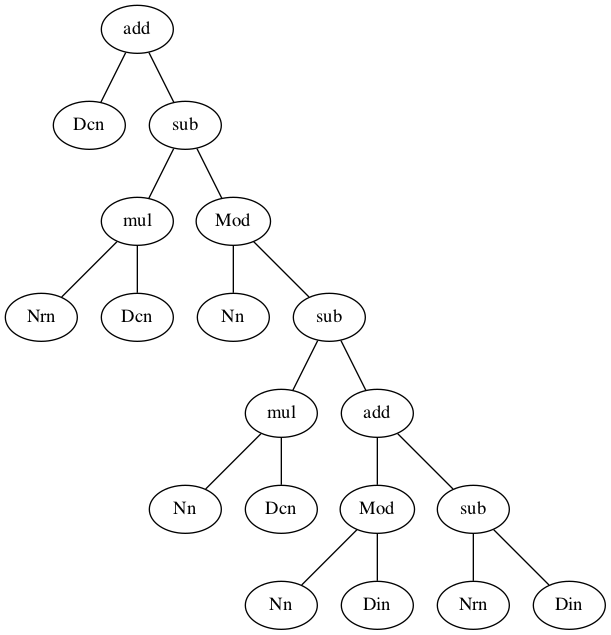

In [23]:
best_individual = tools.selBest(pop, k=1)[0]
nodes, edges, labels = gp.graph(best_individual)
# print('Fitness of the best individual: ', evaluation(best_individual)[0])

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("./figures/tree.png")

pil_img = Image(filename='./figures/tree.png')
display(pil_img)

Text(0.5, 1.0, 'berlin52 symetric graph')

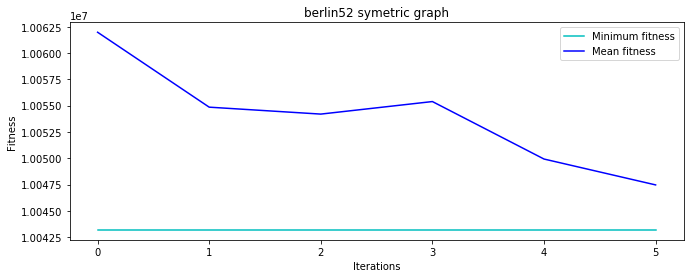

In [24]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("berlin52 symetric graph")